In [3]:
from Config import Config
from torch.utils.data import DataLoader
import torch
import wandb
import gc
import torch.nn.functional as F
from lightning.pytorch.loggers import WandbLogger
import os
from lightning import Trainer, seed_everything
from dataloader import CustomTextDataset
import argparse
import pandas as pd
from Seq2SeqModel import Seq2SeqModel
import seaborn as sns
import json
from utils import decoder_function
from tqdm import tqdm

In [4]:
## Dataloader
TEST_BATCH_SIZE = 2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DATASET_PATH = os.path.join("..","dataset", "dakshina_dataset_v1.0", "ta", "lexicons")
test_df = pd.read_csv(os.path.join(DATASET_PATH, "ta.translit.sampled.test.idx.csv"))

with open(os.path.join(DATASET_PATH,"tamil_token_index.json"),'r', encoding="utf-8") as f:
	tamil_idx = json.load(f)
tamil_idx_to_char = {j:i for i,j in tamil_idx.items()}

with open(os.path.join(DATASET_PATH,"english_token_index.json"),'r', encoding="utf-8") as f:
	english_idx = json.load(f)
english_idx_to_char = {j:i for i,j in english_idx.items()}

english_idx_to_char[26] = "-"
tamil_idx_to_char[48] = "-"


config = Config()

test_dataset = CustomTextDataset(
        dataset_df=test_df[:3],
        X_max_length=config.X_max_length,
        Y_max_length=config.Y_max_length,
        X_vocab_size=config.X_vocab_size,
        Y_vocab_size=config.Y_vocab_size,
        X_padding_idx=config.X_padding_idx,
        Y_padding_idx=config.Y_padding_idx,
    )

lit_model = Seq2SeqModel(config=config)

In [26]:
X, Y_decoder_ip, Y_decoder_op, X_len, Y_decoder_ip_len, Y_decoder_op_len = test_dataset.__getitem__(0)

X_native = decoder_function(character_idx_seq=','.join([str(i) for i in X.detach().numpy()]), idx_to_char_dict=english_idx_to_char)
Y_native = decoder_function(character_idx_seq=','.join([str(i) for i in Y_decoder_op.detach().numpy()]), idx_to_char_dict=tamil_idx_to_char)


X = torch.unsqueeze(X, 0).to(device)
X_len = torch.unsqueeze(X_len, 0).to(device)
Y_decoder_ip = torch.unsqueeze(Y_decoder_ip, 0).to(device)

print(X.shape)

torch.Size([1, 30])


In [39]:
Y_decoder_op_len

tensor(7, dtype=torch.int32)

In [10]:
Y_decoder_ip.shape

torch.Size([1, 27])

In [5]:
(logits, attn_weight_list) = lit_model(X, X_len, Y_decoder_ip)
attn_weight_list = attn_weight_list.squeeze(0).permute(1,0) # reshaped to [X_max_len, Y_max_len]

## Make an inference code where it iteratively go over the decoder

In [5]:
## batch size = 1 for now
## Iterate only for the actual decoder length. this will reduce the computation
test_correct_prediction_count = 0
## TODO For loop over the test data. individual samples

for idx in tqdm(range(len(test_dataset))):
    X, Y_decoder_ip, Y_decoder_op, X_len, Y_decoder_ip_len, Y_decoder_op_len = test_dataset.__getitem__(idx)
    X = torch.unsqueeze(X, 0).to(device)
    X_len = torch.unsqueeze(X_len, 0).to(device)
    Y_decoder_ip = torch.unsqueeze(Y_decoder_ip, 0).to(device)
    prediction_list = []
    for i in range(1,Y_decoder_op_len + 1): ## get the len of the decoder input 
        new_decoder_ip = torch.unsqueeze(torch.cat([Y_decoder_ip[0][:i],  torch.tensor([config.Y_padding_idx]*(config.Y_max_length - i))]),axis = 0)

        ## Prediction
        (logits, attn_weight_list) = lit_model(X, X_len, new_decoder_ip)
        logits2 = logits.view(-1, logits.size(-1))
        prob = F.softmax(logits2, dim=1)
        preds = torch.argmax(prob, dim=1)
        prediction_list.append(torch.unsqueeze(preds[i], dim=0))

    prediction_tensor = torch.cat(prediction_list)
    correct = prediction_tensor == Y_decoder_op[:Y_decoder_op_len]
    if torch.all(correct):
        test_correct_prediction_count += 1
    else:
        test_correct_prediction_count += 0

test_accuracy = test_correct_prediction_count / len(test_dataset)
print("Test accuracy",test_accuracy)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:06<00:00,  2.32s/it]

Test accuracy 0.0


In [6]:
test_correct_prediction_count

0

In [16]:
print(prob.sum(dim=1),prob.sum(dim=1).shape)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>) torch.Size([27])


In [20]:
prob[0]

tensor([0.0213, 0.0217, 0.0199, 0.0198, 0.0199, 0.0204, 0.0218, 0.0210, 0.0203,
        0.0215, 0.0208, 0.0200, 0.0208, 0.0203, 0.0210, 0.0205, 0.0207, 0.0222,
        0.0204, 0.0216, 0.0212, 0.0209, 0.0214, 0.0205, 0.0210, 0.0219, 0.0200,
        0.0207, 0.0211, 0.0202, 0.0200, 0.0202, 0.0211, 0.0214, 0.0201, 0.0203,
        0.0204, 0.0209, 0.0217, 0.0214, 0.0218, 0.0209, 0.0211, 0.0205, 0.0213,
        0.0208, 0.0202, 0.0210], grad_fn=<SelectBackward0>)

In [23]:
preds

tensor([17, 17, 17,  6,  6,  6, 38, 38, 38, 17, 17, 17, 17, 17, 17,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1])

c:\Users\yuvar\miniconda3\envs\fastapi\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2947 (\N{TAMIL SIGN VISARGA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\yuvar\miniconda3\envs\fastapi\Lib\site-packages\seaborn\utils.py:61: UserWarning: Matplotlib currently does not support Tamil natively.
  fig.canvas.draw()
c:\Users\yuvar\miniconda3\envs\fastapi\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2986 (\N{TAMIL LETTER PA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\yuvar\miniconda3\envs\fastapi\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 3006 (\N{TAMIL VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\yuvar\miniconda3\envs\fastapi\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2992 (\N{TAMIL LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\yuvar\miniconda3\envs\fastapi\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 3021 (\N{TAMIL SIGN

<Axes: >

c:\Users\yuvar\miniconda3\envs\fastapi\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 2947 (\N{TAMIL SIGN VISARGA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\yuvar\miniconda3\envs\fastapi\Lib\site-packages\IPython\core\events.py:82: UserWarning: Matplotlib currently does not support Tamil natively.
  func(*args, **kwargs)
c:\Users\yuvar\miniconda3\envs\fastapi\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 2986 (\N{TAMIL LETTER PA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\yuvar\miniconda3\envs\fastapi\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 3006 (\N{TAMIL VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\yuvar\miniconda3\envs\fastapi\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 2992 (\N{TAMIL LETTER RA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\yuvar\miniconda3\envs\fastapi\Lib\site-packages\IPython\c

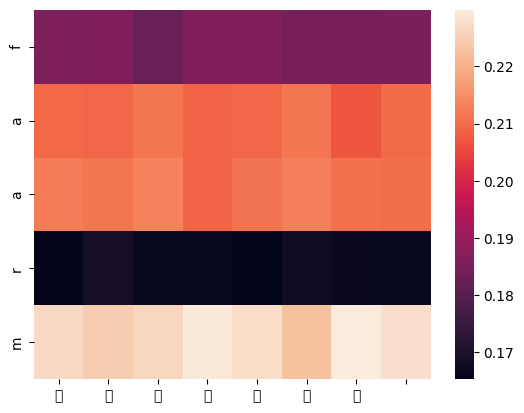

In [60]:
#attn_weight_list[:X_len.cpu().detach().numpy(),:Y_decoder_ip_len].cpu().detach().numpy()
data = attn_weight_list[:X_len,:Y_decoder_ip_len].detach().numpy()
sns.heatmap(data, xticklabels=Y_native[:Y_decoder_ip_len], yticklabels=X_native[:X_len])


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.font_manager as fm

data = {'Column 1': ['வரிசை 1', 'வரிசை 2', 'வரிசை 3'], 
        'Column 2': ['எண் 1', 'எண் 2', 'எண் 3'],
        'Column 3': [10, 20, 30]} 
df = pd.DataFrame(data)

font_names = [f.name for f in fm.fontManager.ttflist]
print(font_names)

plt.rcParams['font.family'] = 'Latha' # Replace 'Latha' with your font name
heatmap = sns.heatmap(pd.crosstab(df['Column 1'], df['Column 2'], df['Column 3']), annot=True, fmt="d")

# Set labels with Tamil font
heatmap.set_xlabel("எக்ஸ்-அச்சு")
heatmap.set_ylabel("ஒய்-அச்சு")
heatmap.set_title("வெப்ப வரைபடம்")

# Adjust font size of labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=10)

plt.show()

['STIXSizeFiveSym', 'STIXSizeOneSym', 'STIXGeneral', 'STIXSizeThreeSym', 'cmex10', 'DejaVu Serif', 'STIXSizeOneSym', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans Mono', 'STIXSizeThreeSym', 'cmmi10', 'STIXGeneral', 'DejaVu Serif', 'STIXNonUnicode', 'DejaVu Sans Mono', 'cmsy10', 'DejaVu Sans', 'cmb10', 'STIXNonUnicode', 'STIXGeneral', 'DejaVu Serif', 'STIXSizeFourSym', 'DejaVu Sans Mono', 'STIXNonUnicode', 'STIXSizeTwoSym', 'STIXSizeFourSym', 'cmss10', 'DejaVu Sans', 'DejaVu Serif', 'STIXGeneral', 'cmr10', 'cmtt10', 'STIXNonUnicode', 'DejaVu Serif Display', 'DejaVu Sans Display', 'STIXSizeTwoSym', 'DejaVu Sans Mono', 'Georgia', 'Dubai', 'Linux Biolinum G', 'Rubik', 'Noto Sans Armenian', 'Lucida Handwriting', 'Microsoft PhagsPa', 'Book Antiqua', 'Leelawadee', 'Segoe UI Variable', 'Javanese Text', 'Liberation Sans', 'Arial', 'Frank Ruehl CLM', 'MT Extra', 'Gentium Basic', 'DejaVu Sans Mono', 'Arial', 'Segoe UI', 'Segoe UI Historic', 'Microsoft New Tai Lue', 'Gentium Basic', 'Comic Sans MS', 

ValueError: values cannot be used without an aggfunc.

In [1]:
import matplotlib.font_manager as fm
font_names = [f.name for f in fm.fontManager.ttflist]
print("Available fonts:", font_names)

Available fonts: ['STIXSizeFiveSym', 'STIXSizeOneSym', 'STIXGeneral', 'STIXSizeThreeSym', 'cmex10', 'DejaVu Serif', 'STIXSizeOneSym', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans Mono', 'STIXSizeThreeSym', 'cmmi10', 'STIXGeneral', 'DejaVu Serif', 'STIXNonUnicode', 'DejaVu Sans Mono', 'cmsy10', 'DejaVu Sans', 'cmb10', 'STIXNonUnicode', 'STIXGeneral', 'DejaVu Serif', 'STIXSizeFourSym', 'DejaVu Sans Mono', 'STIXNonUnicode', 'STIXSizeTwoSym', 'STIXSizeFourSym', 'cmss10', 'DejaVu Sans', 'DejaVu Serif', 'STIXGeneral', 'cmr10', 'cmtt10', 'STIXNonUnicode', 'DejaVu Serif Display', 'DejaVu Sans Display', 'STIXSizeTwoSym', 'DejaVu Sans Mono', 'Georgia', 'Dubai', 'Linux Biolinum G', 'Rubik', 'Noto Sans Armenian', 'Lucida Handwriting', 'Microsoft PhagsPa', 'Book Antiqua', 'Leelawadee', 'Segoe UI Variable', 'Javanese Text', 'Liberation Sans', 'Arial', 'Frank Ruehl CLM', 'MT Extra', 'Gentium Basic', 'DejaVu Sans Mono', 'Arial', 'Segoe UI', 'Segoe UI Historic', 'Microsoft New Tai Lue', 'Gentium Basic', 

In [2]:
"Tam" in font_names

False

In [ ]:
# (Devanagari, Nepali, Sanskrit, and Marathi Font).

## Prediction with color coding

In [9]:
import pandas as pd
from IPython.display import display, HTML

def color_code_text(row):
    input_text = row['Input']
    actual_text = row['Actual_Y']
    pred_text = row['Prediction']
    
    colored = []
    # Compare up to the shorter length
    for i in range(min(len(actual_text), len(pred_text))):
        char = pred_text[i]
        color = 'green' if char == actual_text[i] else 'red'
        colored.append(f"<span style='color:{color}'>{char}</span>")
    
    # Extra predicted chars (over-prediction)
    for char in pred_text[len(actual_text):]:
        colored.append(f"<span style='color:red'>{char}</span>")
    
    # Missing chars (under-prediction)
    for _ in actual_text[len(pred_text):]:
        colored.append(f"<span style='color:red'>_</span>")
    
    return ''.join(colored)

# Assuming `df` is your DataFrame with the three columns
df = pd.DataFrame({
    'Input':   ["Testing1","Testing2"],  # your input data
    'Actual_Y':  ["Test1","Test2"],  # ground truth
    'Prediction':["Tes_1","Test_"]  # model outputs
})

# Apply color coding to first 10 rows
subset = df.head().copy()
subset['colored prediction'] = subset.apply(color_code_text, axis=1)

# Generate HTML table without escaping HTML tags
html_table = subset[['Input', 'Actual_Y', 'colored prediction']] \
    .to_html(escape=False, index=False)

# Display in a Jupyter notebook
display(HTML(html_table))


Input,Actual_Y,colored prediction
Testing1,Test1,Tes_1
Testing2,Test2,Test_


In [13]:
## load the prediction and make the vizualization

pred = pd.read_csv(os.path.join("..","predictions_vanilla","basic_prediction.csv"))

In [14]:
# Apply color coding to first 10 rows
subset = pred.head().copy()
subset['colored prediction'] = subset.apply(color_code_text, axis=1)

# Generate HTML table without escaping HTML tags
html_table = subset[['Input', 'Actual_Y', 'colored prediction']] \
    .to_html(escape=False, index=False)

# Display in a Jupyter notebook
display(HTML(html_table))

Input,Actual_Y,colored prediction
faarm-------------------------,ஃபார்ம்\n,பார்ம்\nு
farm--------------------------,ஃபார்ம்\n,பார்ம்\nு
form--------------------------,ஃபார்ம்\n,போர்ம்\nு
hpaarm------------------------,ஃபார்ம்\n,பார்ம்\nு
face--------------------------,ஃபேஸ்\n,பாக்கி


In [11]:
html_table

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Input</th>\n      <th>Actual_Y</th>\n      <th>colored prediction</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <td>faarm-------------------------</td>\n      <td>ஃபார்ம்\\n</td>\n      <td><span style=\'color:red\'>ப</span><span style=\'color:red\'>ா</span><span style=\'color:red\'>ர</span><span style=\'color:red\'>்</span><span style=\'color:red\'>ம</span><span style=\'color:red\'>்</span><span style=\'color:red\'>\\n</span><span style=\'color:red\'>ு</span></td>\n    </tr>\n    <tr>\n      <td>farm--------------------------</td>\n      <td>ஃபார்ம்\\n</td>\n      <td><span style=\'color:red\'>ப</span><span style=\'color:red\'>ா</span><span style=\'color:red\'>ர</span><span style=\'color:red\'>்</span><span style=\'color:red\'>ம</span><span style=\'color:red\'>்</span><span style=\'color:red\'>\\n</span><span style=\'color:red\'>ு</span></td>\n    </tr>\n    <tr>\n      <td>form-

In [12]:
pred

,Input,Actual_Y,Prediction,Actual_Y_idx,Prediction_idx
0,faarm-------------------------,ஃபார்ம்\n,பார்ம்\nு,"[2, 24, 36, 27, 47, 25, 47, 1]","[24, 36, 27, 47, 25, 47, 1, 39]"
1,farm--------------------------,ஃபார்ம்\n,பார்ம்\nு,"[2, 24, 36, 27, 47, 25, 47, 1]","[24, 36, 27, 47, 25, 47, 1, 39]"
2,form--------------------------,ஃபார்ம்\n,போர்ம்\nு,"[2, 24, 36, 27, 47, 25, 47, 1]","[24, 45, 27, 47, 25, 47, 1, 39]"
3,hpaarm------------------------,ஃபார்ம்\n,பார்ம்\nு,"[2, 24, 36, 27, 47, 25, 47, 1]","[24, 36, 27, 47, 25, 47, 1, 39]"
4,face--------------------------,ஃபேஸ்\n,பாக்கி,"[2, 24, 42, 34, 47, 1]","[24, 36, 14, 47, 14, 37]"
...,...,...,...,...,...
95,adiyum------------------------,அடியும்\n,அடியும்\n,"[3, 19, 37, 26, 39, 25, 47, 1]","[3, 19, 37, 26, 39, 25, 47, 1]"
96,atiyum------------------------,அடியும்\n,அடியும்\n,"[3, 19, 37, 26, 39, 25, 47, 1]","[3, 19, 37, 26, 39, 25, 47, 1]"
97,adiyai------------------------,அடியை\n,அடியை\n,"[3, 19, 37, 26, 43, 1]","[3, 19, 37, 26, 43, 1]"
98,atiyai------------------------,அடியை\n,அடியை\n,"[3, 19, 37, 26, 43, 1]","[3, 19, 37, 26, 43, 1]"
